# Coordinates

In here, we will verify coordinate transformations.

Reference:

[Coordinate Systems](http://astro.utoronto.ca/~bovy/AST1420/notes/notebooks/A.-Coordinate-systems.html)

[Coordinate Transformations](https://github.com/jobovy/stellarkinematics/blob/master/stellarkinematics.pdf)


## Conclusions So Far

* Spherical to Cartesian transformation and its inverse work
* The same tranformations work for coordinates in the ICRS and Galactic frames
* Transformations from spherical motions work and inversely
* 3d distance from a point (center) produce the same results (i.e., distance calculated in ICRS frame matches distance calculated in the Galactic frame)
* value of radial velocity does not affect trajectory over time in the (l,b) plane (probably not in the ra, dec plane, too); rv appears to affect __when__ an object gets to a particular point.
* caculating angular separation after `apply_space_motion` appears to produce same result as $dt*\sqrt{pmra\_cosdec^2+pmdec^2}$
* hand extrapolation of position i.e., $RA_t=RA_0+\mu_{RA}*dt$ approximates `apply_space_motion` for up to about 10,000 years, then starts to diverge
* when no RV supplied, astropy supplies 0.0 km/s when converting to caresian velocities


## Still to Investigate

* ICRS to Galactic coordinate transformations and inverse
* Rest frames (perhaps in a different Notebook) LSR,  Galactic LSR
* Astropy coordinate behavior with and without RV supplied. When no RV supplied, what value does it use when computing d_xyz
* Verify `apply_space_motion` calculations
* Verify `coord.separation()` is great circle distance


## Load up some data

In [1]:
import sys, os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 



sys.path.append('..')
import astropy.units as u


print(f'Current Working Directory: {os.getcwd()}')

from locate_cluster_outliers.src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers
from locate_cluster_outliers.src.gaiastars import gaiastars as gs, gaiadr2xdr3

#construct a dict mapping cluster name in Table1a to its name in Simabad
name_mapper = {'Hyades': 'Hyades',
               'Coma Berenices Cluster':'ComaBer',
               'Pleiades':'Pleiades',
               'Praesepe': 'Praesepe',
               'alpha Per':'alphaPer',
               'IC 2391': 'IC2391',
               'IC 2602': 'IC2602',
               'Blanco 1': 'Blanco1',
               'NGC 2451A': 'NGC2451'}
cluster_info = querySIMBAD(name_mapper, formatGaia=True)

clusters = ['Pleiades', 'Hyades']

print(cluster_info.loc['Pleiades'])

print('\n------------ Gaia Known Members ------------')

cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

cluster_known_members={}
xmatches = {}
for cl in cluster_names:
    known_members_dr2 = list(cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_known_members[cl]=gs(name=f'{cl} Known Members')
    km = list(cluster_members.query('Cluster==@cl').index)
    cluster_known_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3')
    # dr3 thing, some of the stars have no parallax, so ditch them
    nanp = np.isnan(cluster_known_members[cl].objs.parallax)
    bogus_stars = list(cluster_known_members[cl].objs.index[nanp])
    cluster_known_members[cl].objs.drop(labels=bogus_stars, inplace=True)


Current Working Directory: /home/kevin_leo_mcmanus/locate_cluster_outliers/WorksInProgress
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


typed_id  parallax parallax_error    ra    ra_error   dec    dec_error    pmra     pmdec   radial_velocity rv_error cluster                          coords                       
            mas                   "h:m:s"           "d:m:s"             mas / yr  mas / yr      km / s      km / s                                 deg,deg,pc                     
-------- --------- -------------- -------- -------- -------- --------- --------- --------- --------------- -------- -------- -----------------------------------------------------
Pleiades     7.364              3 03 47 00        4 +24 07.0         4    19.997   -45.548           5.650    0.090 Pleiades 56.75009432548025,24.11647057028541,135.7958527032827

------------ Gaia Known Members ------------
['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.c

## Equatorial to Cartesian

* spherical coords in $(r, \phi, \theta)$
* earth at center
* $RA_0$ points to vernal equinox
* $\phi$ = $RA$ denoted $\alpha$
* $\delta$ is complement of $\theta$, that is $\theta = 90^\circ - \delta$

Then

\begin{align*}
x  & = r\ sin(\theta)\ cos(\phi) \\y &= r\ sin(\theta)\ cos(\phi)\\z &= r\ cos(\theta)
\end{align*}

Note: $cos\ \theta =\ sin(\frac{\pi}{2} - \theta)$ and similarly  $sin\ \theta =\ cos(\frac{\pi}{2} - \theta)$ so we can ditch the $\theta$ term above and rewrite the transformation as:

\begin{align*}
x  & = r\ cos(\delta)\ cos(\alpha) \\y &= r\ cos(\delta)\ sin(\alpha)\\z &= r\ sin(\delta)
\end{align*}

which agrees with Van Leeuwen's notation.

**TODO Check the above**

In [2]:
#old code - do not run!
from astropy.coordinates import Angle
def eq_to_cartesian(ra, dec, r):
    theta = Angle(90*u.degree) - dec
    phi = ra
    x = r * np.sin(theta)*np.cos(phi)
    y = r * np.sin(theta)*np.sin(phi)
    z = r * np.cos(theta)
    
    xyz = np.array([x, y, z])
    return xyz

In [3]:
from astropy.coordinates import Angle
def eq_to_cartesian(ra, dec, r):

    x = r * np.cos(dec)*np.cos(ra)
    y = r * np.cos(dec)*np.sin(ra)
    z = r * np.sin(dec)
    
    xyz = np.array([x, y, z])
    return xyz

In [4]:
coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True)

In [5]:
coords[:5].galactic

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(169.81087757, -27.53691602, 144.41988434),
     (172.81517346, -25.75711759, 129.82392516),
     (173.00110796, -24.74661908, 130.15583931),
     (171.26227137, -27.05344241, 134.87196117),
     (171.56499261, -26.74471188, 125.92336759)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(42.03512862, -17.12004   , 3.24306035),
     (47.98415123, -18.32565445, 8.91076279),
     (        nan,          nan,        nan),
     (        nan,          nan,        nan),
     (        nan,          nan,        nan)]>

In [6]:
xyz_calc = eq_to_cartesian(coords.ra, coords.dec, coords.distance)
xyz_act = coords.cartesian.xyz.value

Text(0.5, 0.98, 'Coordinate Transformation')

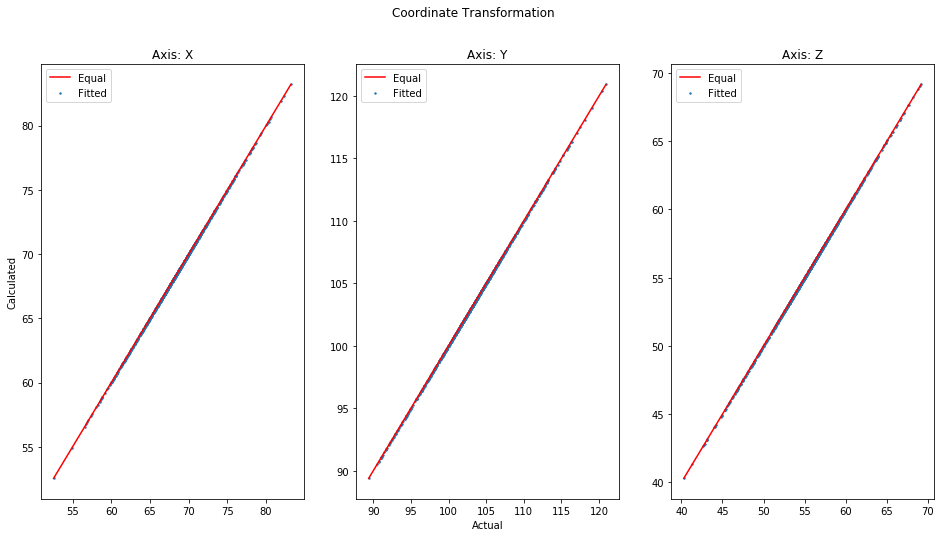

In [7]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):
    vmin = xyz_act[i].min()
    vmax = xyz_act[i].max()
    ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(xyz_act[i], xyz_calc[i], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('Calculated')
ax[1].set_xlabel('Actual')
fig.suptitle('Coordinate Transformation')

In [8]:

for i,d in zip([0,1,2],list('XYZ')):
    print(f'All close in {d}: {np.allclose(xyz_calc[i], xyz_act[i])}')

All close in X: True
All close in Y: True
All close in Z: True


Plots above show agreement between the calculated cartesian coordinates and those produced by astropy.

## Cartesian Transformation of Motion

Can we calculate motion in X, Y, Z from `pm_ra_cosdec`, `pm_dec` and `radial_velocity`?

In [9]:
def pm_to_dxyz(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity):
    # radial_velocity in km/sec, so need convert the motions to km/s
    #k = 4.74047 #transformation from 1 mas/year at 1kpc to km/sec
    #r_pm_ra_cosdec = k*distance*pm_ra_cosdec/1000
    #r_pm_dec = k*distance*pm_dec/1000
    v_ra = (pm_ra_cosdec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    v_dec = (pm_dec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    
    #form the derivative matrix
    sin_alpha = np.sin(ra); cos_alpha = np.cos(ra)
    sin_delta = np.sin(dec); cos_delta=np.cos(dec)
    
    #shape should be 3x3xN
    l = len(sin_alpha)
    dm = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                  cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                  sin_delta,             np.zeros(l),  cos_delta])

    eq_v = np.array([radial_velocity,v_ra, v_dec])
    d_xyz = np.array([dm[:,i].reshape(3,3).dot(eq_v[:,i].reshape(3,1)) for i in range(l)]).squeeze().transpose()
    
    return d_xyz

In [10]:
d_xyz_calc = pm_to_dxyz(coords.ra, coords.dec, coords.distance,
                        coords.pm_ra_cosdec, coords.pm_dec, coords.radial_velocity)
d_xyz_act = coords.velocity.d_xyz.value

Text(0.5, 0.98, 'Velocity Transformation')

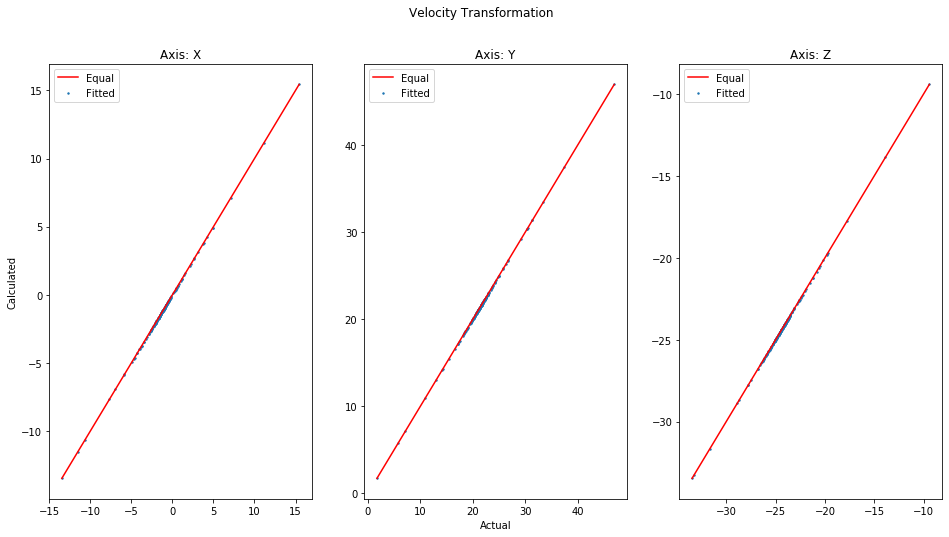

In [11]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):
    vmin = np.nanmin(d_xyz_act[i])
    vmax = np.nanmax(d_xyz_act[i])
    ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(d_xyz_act[i], d_xyz_calc[i], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('Calculated')
ax[1].set_xlabel('Actual')
fig.suptitle('Velocity Transformation')

In [12]:
for i,d in zip([0,1,2],list('XYZ')):
    print(f'All close in {d}: {np.allclose(d_xyz_calc[i], d_xyz_act[i], equal_nan=True)}')

All close in X: True
All close in Y: True
All close in Z: True


Getting same result. **Yay!**

## Compare Galactic XYZ to Equatorial XYZ

Text(0.5, 0.98, 'Galactic v. Equatorial Cartesian')

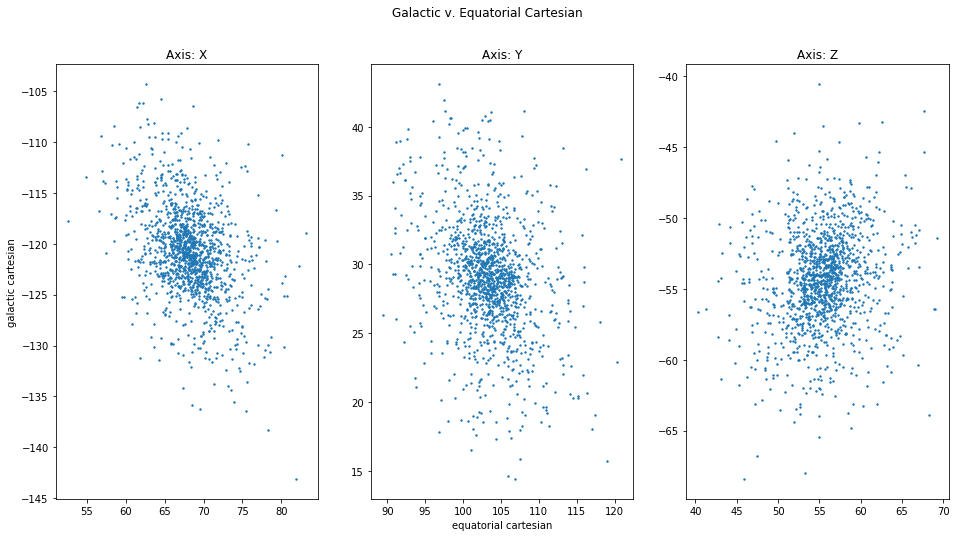

In [13]:
coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True)
eq_xyz = coords.cartesian.xyz.value
gal_xyz = coords.galactic.cartesian.xyz.value

fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):

    ax[i].scatter(eq_xyz[i], gal_xyz[i], s=2)
    ax[i].set_title(f'Axis: {d}')
    #ax[i].legend()
    
ax[0].set_ylabel('galactic cartesian')
ax[1].set_xlabel('equatorial cartesian')
fig.suptitle('Galactic v. Equatorial Cartesian')

No obvious relationship!

## Compare Motion Equatorial versus Galactic

In [14]:
eq_d_xyz = coords.velocity.d_xyz.value
gal_d_xyz = coords.galactic.velocity.d_xyz.value

Text(0.5, 0.98, 'Velocity Comparison')

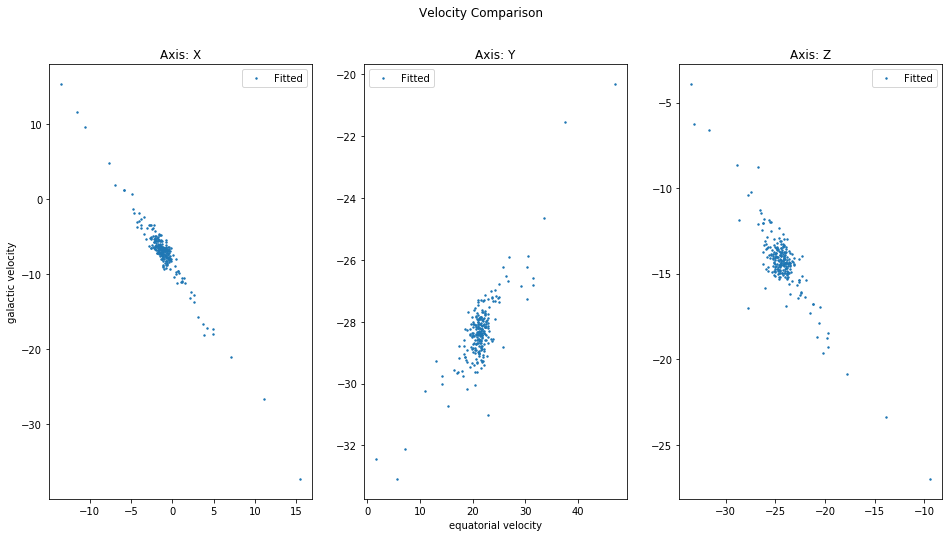

In [15]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):

    ax[i].scatter(eq_d_xyz[i], gal_d_xyz[i], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('galactic velocity')
ax[1].set_xlabel('equatorial velocity')
fig.suptitle('Velocity Comparison')

Quite a bit different and not a linear relationship.

## Galactic Coordinates
Can the same transformation matrices above transform from galactic coordintate to galactic cartesian?

In [16]:
gal_coords = coords.galactic

In [17]:
gal_coords[:5]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(169.81087757, -27.53691602, 144.41988434),
     (172.81517346, -25.75711759, 129.82392516),
     (173.00110796, -24.74661908, 130.15583931),
     (171.26227137, -27.05344241, 134.87196117),
     (171.56499261, -26.74471188, 125.92336759)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(42.03512862, -17.12004   , 3.24306035),
     (47.98415123, -18.32565445, 8.91076279),
     (        nan,          nan,        nan),
     (        nan,          nan,        nan),
     (        nan,          nan,        nan)]>

In [18]:
xyz_calc = eq_to_cartesian(gal_coords.l, gal_coords.b, gal_coords.distance)
xyz_act = gal_coords.cartesian.xyz.value

Text(0.5, 0.98, 'Coordinate Transformation')

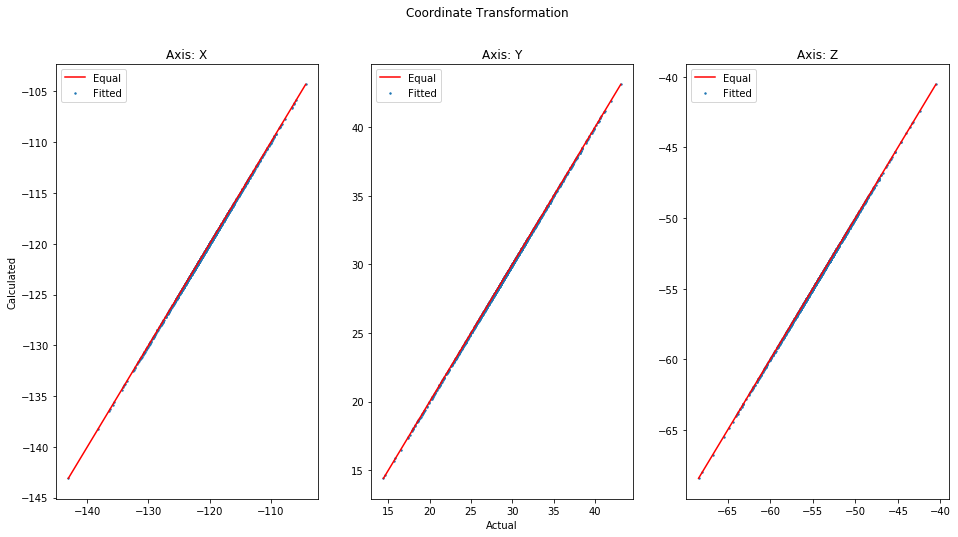

In [19]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):
    vmin = xyz_act[i].min()
    vmax = xyz_act[i].max()
    ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(xyz_act[i], xyz_calc[i], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('Calculated')
ax[1].set_xlabel('Actual')
fig.suptitle('Coordinate Transformation')

In [20]:
for i,d in zip([0,1,2],list('XYZ')):
    print(f'All close in {d}: {np.allclose(xyz_calc[i], xyz_act[i])}')

All close in X: True
All close in Y: True
All close in Z: True


In [21]:
d_xyz_calc = pm_to_dxyz(gal_coords.l, gal_coords.b, gal_coords.distance,
                        gal_coords.pm_l_cosb, gal_coords.pm_b, gal_coords.radial_velocity)
d_xyz_act = gal_coords.velocity.d_xyz.value

Text(0.5, 0.98, 'Velocity Transformation')

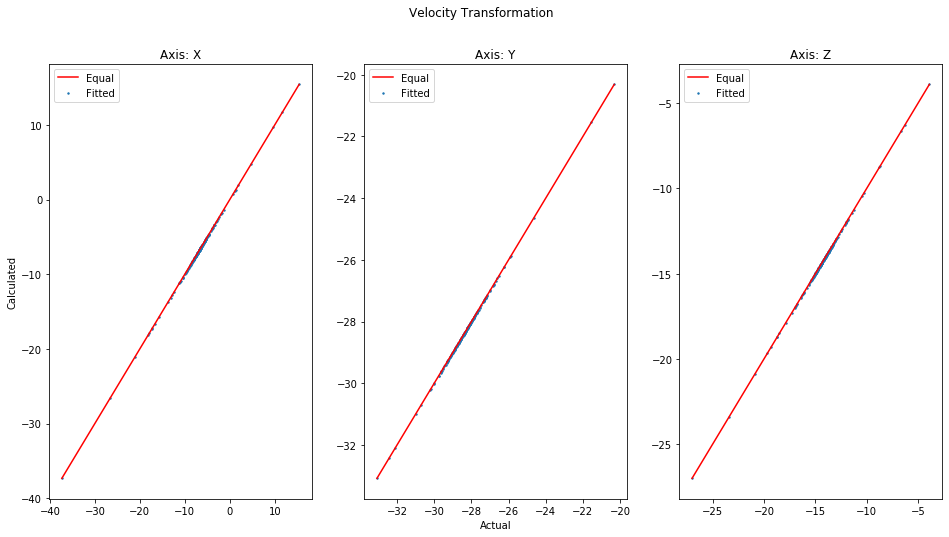

In [22]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):
    vmin = np.nanmin(d_xyz_act[i])
    vmax = np.nanmax(d_xyz_act[i])
    ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(d_xyz_act[i], d_xyz_calc[i], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('Calculated')
ax[1].set_xlabel('Actual')
fig.suptitle('Velocity Transformation')

In [23]:
for i,d in zip([0,1,2],list('XYZ')):
    print(f'All close in {d}: {np.allclose(d_xyz_calc[i], d_xyz_act[i], equal_nan=True)}')

All close in X: True
All close in Y: True
All close in Z: True


Same transformation works from galactic to galactic cartesian as from equatorial to equatorial cartesian.  Makes sense because both coordinate systems are spherical coordinates. 

## Compare Distance Computed in Galactic Coordinates to Distance Computed in Equatorial Coordinates

In [24]:
eq_cen = cluster_info.loc['Pleiades']['coords']
gal_cen = cluster_info.loc['Pleiades']['coords'].galactic
eq_coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True)
gal_coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True).galactic

eq_dist = eq_cen.separation_3d(eq_coords)
gal_dist = gal_cen.separation_3d(gal_coords)

Text(0, 0.5, 'Computed with Galactic')

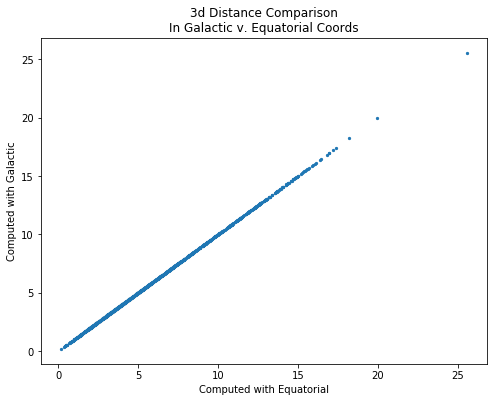

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(eq_dist, gal_dist, s=5)
ax.set_title('3d Distance Comparison\nIn Galactic v. Equatorial Coords')
ax.set_xlabel('Computed with Equatorial')
ax.set_ylabel('Computed with Galactic')

In [26]:
np.allclose(eq_dist, gal_dist)

True

Just for grins, let's repeat the plot of the galactic velocity vector versus the equatorial velocity vector.

## Space Velocity Comparison

In [27]:
eq_coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True)
d_xyz = eq_coords.velocity.d_xyz
eq_vel = np.sqrt((d_xyz**2).sum(axis=0))

gal_coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True).galactic
d_uvw = gal_coords.velocity.d_xyz # why isn't this property called d_uvw?
gal_vel = np.sqrt((d_uvw**2).sum(axis=0))

Text(0, 0.5, 'Computed with Galactic')

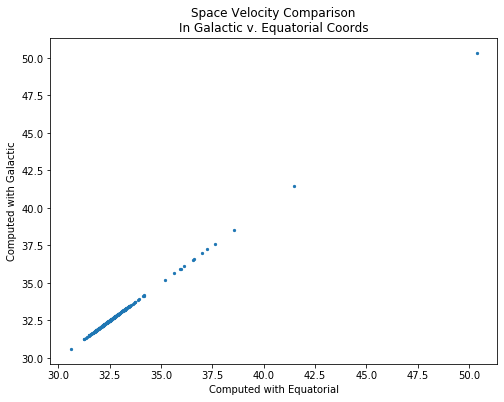

In [28]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(eq_vel, gal_vel, s=5)
ax.set_title('Space Velocity Comparison\nIn Galactic v. Equatorial Coords')
ax.set_xlabel('Computed with Equatorial')
ax.set_ylabel('Computed with Galactic')

In [29]:
np.allclose(eq_vel, gal_vel, equal_nan=True)

True

Text(0.5, 0.98, 'Velocity Transformation')

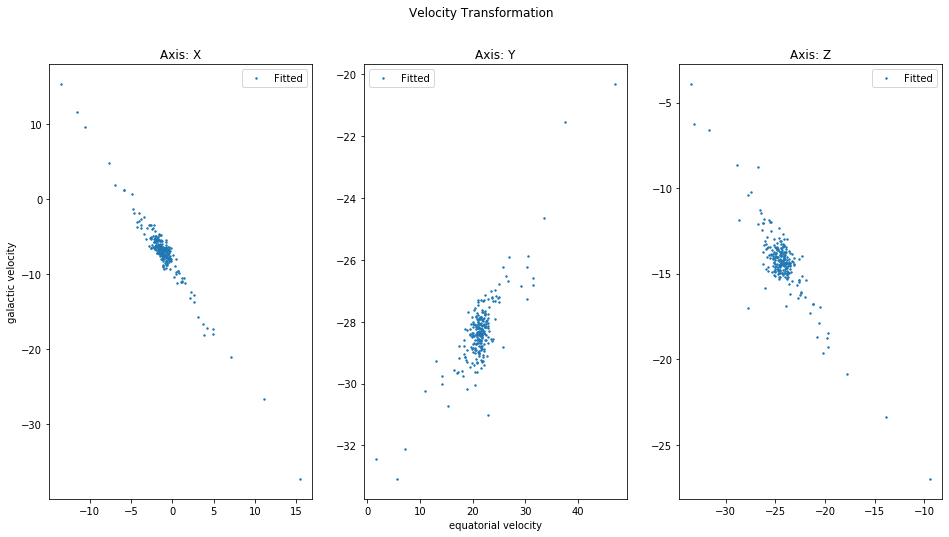

In [30]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in zip([0,1,2],list('XYZ')):
    vmin = np.nanmin(eq_d_xyz[i])
    vmax = np.nanmax(gal_d_xyz[i])
    #ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(d_xyz[i], d_uvw[i], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('galactic velocity')
ax[1].set_xlabel('equatorial velocity')
fig.suptitle('Velocity Transformation')

**Conclusion:** Transforming from equatorial to galactic coordinates does not change the distance between objects nor the magnitude of the space velocity vector. This I had expected.  Surprising, though, given the non-linearity in the transformation between the two frames.

## Cartesian to Spherical

\begin{align*}
\alpha &= arctan2(y, x) \\
\delta &= arctan(z/\sqrt{x^2 + y^2}) \\
r &= \sqrt{x^2 + y^2 + z^2}
\end{align*}

In [31]:
def cartesian_to_spherical(xyz):
    r = np.sqrt((xyz**2).sum(axis=0))
    delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
    alpha = np.arctan2(xyz[1], xyz[0])
    alpha = np.where(alpha<0, alpha+2.0*np.pi, alpha)
    
    spherical = {'distance':r,
                 'alpha': np.rad2deg(alpha),
                 'delta': np.rad2deg(delta)
    }
    
    return spherical
    

In [32]:
eq_coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True)
spherical_act = {'distance': eq_coords.distance.value, 'alpha': eq_coords.ra.to_value(u.degree), 'delta':eq_coords.dec.to_value(u.degree)}
xyz_act = eq_coords.cartesian.xyz.value
spherical_calc = cartesian_to_spherical(xyz_act)

Text(0.5, 0.98, 'Cartesian to Spherical\nCoordinate Transformation')

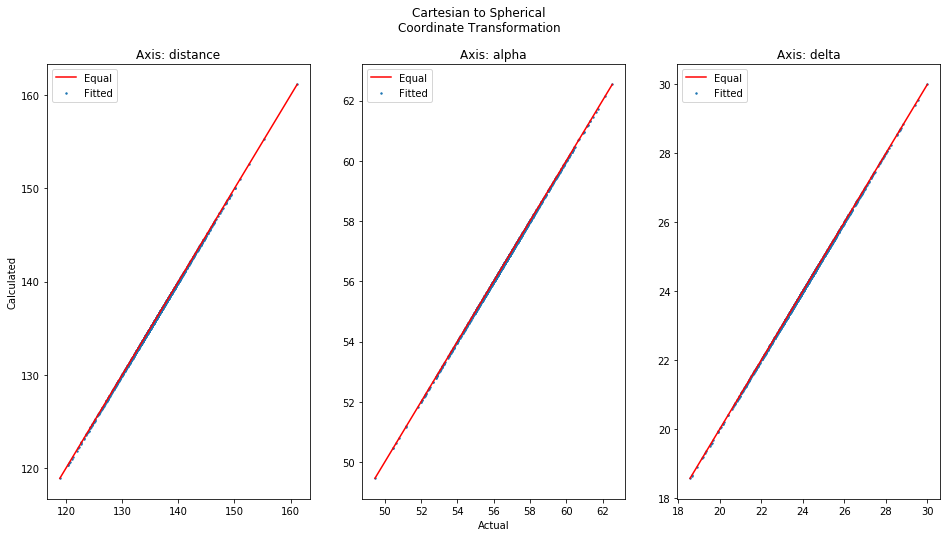

In [33]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in enumerate(['distance', 'alpha', 'delta']):
    vmin = spherical_act[d].min()
    vmax = spherical_act[d].max()
    ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(spherical_act[d], spherical_calc[d], s=2, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('Calculated')
ax[1].set_xlabel('Actual')
fig.suptitle('Cartesian to Spherical\nCoordinate Transformation')

In [34]:
for d in ['distance','alpha', 'delta']:
    print(f'Dimension: {d}, All close: {np.allclose(spherical_act[d], spherical_calc[d])}')

Dimension: distance, All close: True
Dimension: alpha, All close: True
Dimension: delta, All close: True


Looks like those transformations work. **Yay!**

## Cartesian Velocity to Spherical Velocites

In [35]:
def dxyz_to_pm(xyz, d_xyz):
    
    N = xyz.shape[1] # number of stars
    
    #get the spherical coords from xyz:
    spherical = cartesian_to_spherical(xyz)
    
    alpha = np.deg2rad(spherical['alpha'])
    delta = np.deg2rad(spherical['delta'])
    distance = (spherical['distance']*u.pc).to_value(u.km)
    

    #sines and cosines needed for transform matrix
    sin_alpha = np.sin(alpha); cos_alpha = np.cos(alpha)
    sin_delta = np.sin(delta); cos_delta = np.cos(delta)
    
    #form the derivative transformation matrix    
    #dm_x is 9xN in which each column (star) is the star's 3x3 transform matrix in row-major form.
    dm_x = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                  cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                  sin_delta,             np.zeros(N),  cos_delta])

    #rearrange dm_x to be Nx3x3, i.e. stars on the high order axis
    dm_t = dm_x.transpose().reshape(-1, 3, 3)
    assert dm_t.shape == (N, 3, 3)
    
    # need the invers of the transform matrix
    # invert them all in one go; linalg.inv operates on the two lowest order dims
    dm_i = np.linalg.inv(dm_t)
    assert dm_i.shape == (N, 3, 3)

    #get the velocities in km/s:
    #for each star, pre-multiply its velocity vector (as column matrix) by its inverted transform matrix.
    #result for each star is 3x1 col vector; resulting matrix across all stars is Nx3x1
    d_spherical_kms = np.array([dm_i[i].dot(d_xyz[:,i].reshape(3,1)) for i in range(N)])
    assert d_spherical_kms.shape == (N, 3, 1)
    
    d_spherical_kms = d_spherical_kms.squeeze().transpose()
    assert d_spherical_kms.shape == (3, N)
    
    #for reference, how we transform pm_ra_cosdec in mas/year to km/s
    #v_ra = (pm_ra_cosdec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    
    #convert to mas/year for proper motions
    d_spherical = {'radial_velocity': d_spherical_kms[0]*u.km/u.second,
                   'pm_ra_cosdec':  ((d_spherical_kms[1]/distance)*u.radian/u.second).to(u.mas/u.year),
                   'pm_dec': ((d_spherical_kms[2]/distance)*u.radian/u.second).to(u.mas/u.year)}
    
    return d_spherical

In [36]:
eq_coords = cluster_known_members['Pleiades'].get_coords(recalc=True, default_rv=True)
xyz_act = eq_coords.cartesian.xyz.value
d_xyz_act = eq_coords.velocity.d_xyz.value
pm_act = {'radial_velocity': eq_coords.radial_velocity,
          'pm_ra_cosdec': eq_coords.pm_ra_cosdec,
          'pm_dec':eq_coords.pm_dec}

pm_calc = dxyz_to_pm(xyz_act, d_xyz_act)

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of Space Velocities')

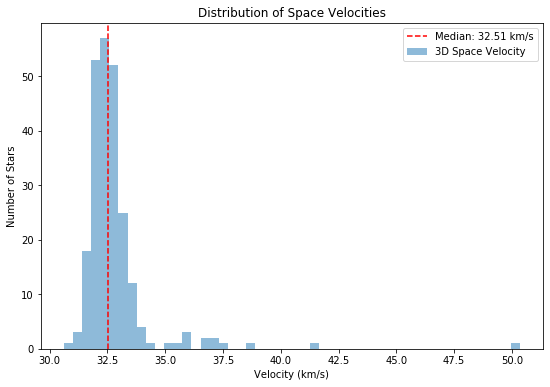

In [37]:
r_dot=d_xyz_act
space_v_3d = np.sqrt((r_dot**2).sum(axis=0))
med_v = np.median(space_v_3d[np.isfinite(space_v_3d)])

fig = plt.figure(figsize=(9,6))
ax = fig.subplots(1,1)


ax.hist(space_v_3d, label='3D Space Velocity', alpha=0.5, bins=50)
ax.axvline(med_v, ls='dashed',color='red', label = f'Median: {med_v:.2f} km/s')
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Number of Stars')

ax.legend()
ax.set_title('Distribution of Space Velocities')

Text(0.5, 0.98, 'Cartesian to Spherical\nVelocity Transformation')

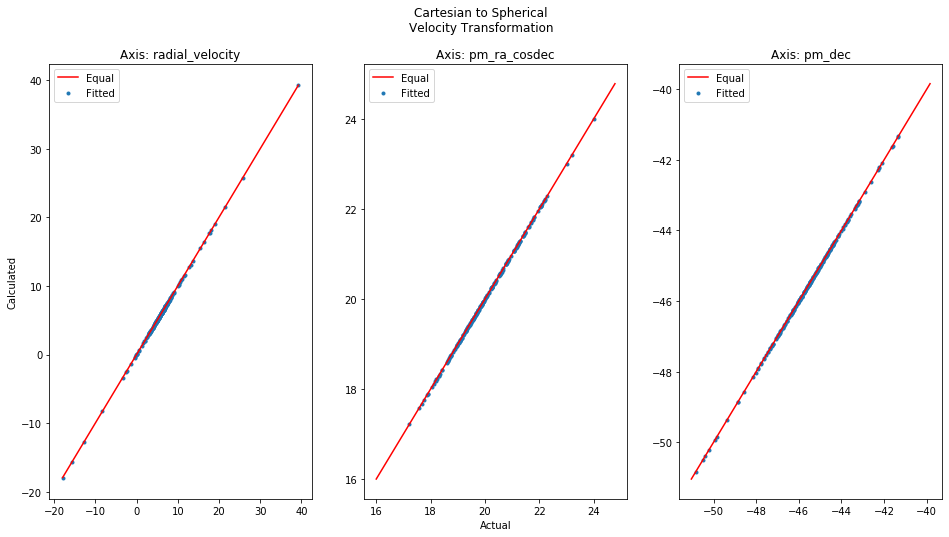

In [38]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,3)

for i,d in enumerate(['radial_velocity', 'pm_ra_cosdec', 'pm_dec']):
    vmin = np.nanmin(pm_act[d]).value
    vmax = np.nanmax(pm_act[d]).value
    ax[i].plot([vmin, vmax],[vmin,vmax], color='red', label='Equal')
    ax[i].scatter(pm_act[d], pm_calc[d], s=9, label='Fitted')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    
ax[0].set_ylabel('Calculated')
ax[1].set_xlabel('Actual')
fig.suptitle('Cartesian to Spherical\nVelocity Transformation')

In [39]:
for d in ['radial_velocity', 'pm_ra_cosdec', 'pm_dec']:
    mask = np.isfinite(pm_calc[d]) #only compare valid values
    print(f'Dimension: {d}, All close: {np.allclose(pm_act[d][mask].value, pm_calc[d][mask].value)}')

Dimension: radial_velocity, All close: True
Dimension: pm_ra_cosdec, All close: True
Dimension: pm_dec, All close: True


Successfully demonstrated transorming from cartesian velocity to proper motion and radial velocity **Yay!**

## Pleiades Trajectory

Let's look at the Pleiades trajectory over, say 250 million years.  First, get cartesian coordinates and velocity, then extrapolate position forward and backward; then take the extrapolated cartesian coords and convert to spherical, then plot.

In [40]:
#cartesian coords
c = cluster_info.loc['Pleiades']['coords'].galactic
xyz=c.cartesian.xyz.reshape(-1,1)

In [41]:
# get cartesian velocity in pc/year
d_xyz=c.velocity.d_xyz.to(u.pc/u.year).reshape(-1,1)
d_xyz

<Quantity [[-6.93007893e-06],
           [-2.91035749e-05],
           [-1.45215545e-05]] pc / yr>

In [42]:
#time
tval = (np.linspace(-125e6, 125e6, 25001)*u.year).reshape(1,-1) #row vector

In [43]:
xyz_t = xyz + d_xyz.dot(tval)

In [44]:
spher_t = cartesian_to_spherical(xyz_t.value)
gal_l = np.where(spher_t['alpha']<0, spher_t['alpha']+360, spher_t['alpha'])

In [45]:
#arrow stuff
start_time_i = 12400
stop_time_i = 12550
l_arrow = gal_l[start_time_i]
b_arrow = spher_t['delta'][start_time_i]*1.20
dl_arrow = gal_l[stop_time_i] - l_arrow
db_arrow = spher_t['delta'][stop_time_i]*1.20 - b_arrow

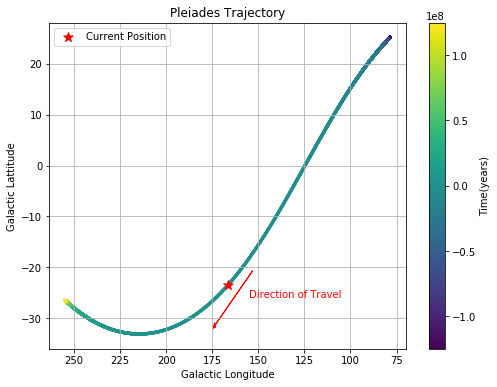

In [46]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
pcm=ax.scatter(gal_l, spher_t['delta'], s=5, c=tval[0])
ax.scatter(c.l, c.b,s=100,marker='*', color='red', label='Current Position')
ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
ax.set_title('Pleiades Trajectory')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Lattitude')
ax.legend()
ax.grid()
ax.invert_xaxis()
fig.colorbar(pcm, label='Time(years)')

### How Does Radial Velocity Affect Trajectory?

Here, we'll do the same backward and forward extrapolation of the Pleiades' position, except with some different radial velocities substituted in.  Plot the results to seem the impact.


In [47]:
#cartesian coords
c = cluster_info.loc['Pleiades']['coords'].galactic
xyz=c.cartesian.xyz.reshape(-1,1)
c.radial_velocity, xyz

(<Quantity 5.65011969 km / s>,
 <Quantity [[-121.10842249],
            [  28.91715788],
            [ -54.19466387]] pc>)

Let's do 0, 2.5, 7.5, and 10 km/s in addition to the actual RV of 5.65 km/s.

In [48]:
# get the xyz and d_xyz (eq works for gal, too!)
xyz = eq_to_cartesian(c.l, c.b, c.distance.value).reshape(-1,1)

In [49]:
xyz

array([[-121.10842249],
       [  28.91715788],
       [ -54.19466387]])

In [50]:
c.cartesian

<CartesianRepresentation (x, y, z) in pc
    (-121.10842249, 28.91715788, -54.19466387)
 (has differentials w.r.t.: 's')>

In [51]:
from astropy.units import Quantity

In [52]:
#radial velocities
rvs = [-10.0, -5.0, 0, 2.5, c.radial_velocity.value, 7.5,10.0]*u.km/u.second
n = len(rvs)
rvs

<Quantity [-10.        ,  -5.        ,   0.        ,   2.5       ,
             5.65011969,   7.5       ,  10.        ] km / s>

In [53]:
d_xyz_trials = pm_to_dxyz(Quantity([c.l]*n), Quantity([c.b]*n), Quantity([c.distance]*n),
                        Quantity([c.pm_l_cosb]*n), Quantity([c.pm_b]*n), rvs)

In [54]:
d_xyz_trials

array([[  7.18125419,   2.72204501,  -1.73716416,  -3.96676875,
         -6.77617728,  -8.42597793, -10.65558251],
       [-31.78987661, -30.72514756, -29.66041851, -29.12805399,
        -28.4572492 , -28.06332493, -27.53096041],
       [ -7.95326864,  -9.94871485, -11.94416105, -12.94188416,
        -14.19906304, -14.93733037, -15.93505347]])

In [55]:
np.allclose(d_xyz_trials[:,2], c.velocity.d_xyz.value)

False

In [56]:
rv_trials = {}
for i, rv in enumerate(rvs):
    d_xyz = (d_xyz_trials[:,i].reshape(3,1)*u.km/u.second).to_value(u.pc/u.year)
    delta_xyz = d_xyz.dot(tval.value)
    xyz_t = xyz + delta_xyz
    spher = cartesian_to_spherical(xyz_t)
    rv_trials[i] = {'rv': rv,
                    'd_xyz': d_xyz,
                    'xyz_t': xyz_t,
                    'spherical': spher}


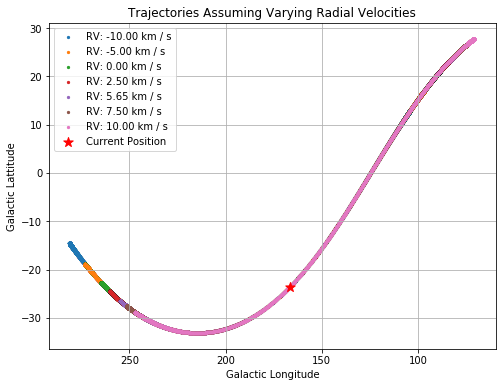

In [57]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

for i in rv_trials:
    ax.scatter(rv_trials[i]['spherical']['alpha'], rv_trials[i]['spherical']['delta'], s=5,
            label = 'RV: {:.2f}'.format(rv_trials[i]['rv']))
ax.scatter(c.l, c.b,s=100,marker='*', color='red', label='Current Position')
#ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
#ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
ax.set_title('Trajectories Assuming Varying Radial Velocities')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Lattitude')
ax.legend()
ax.grid()
ax.invert_xaxis()

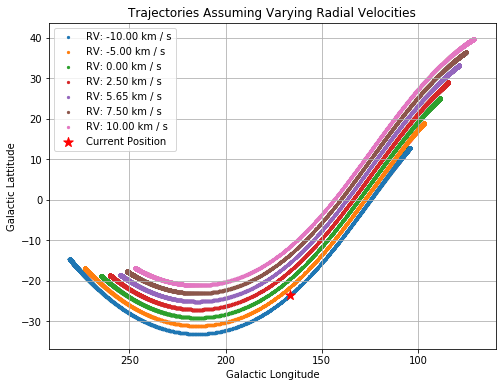

In [58]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

for i in rv_trials:
    ax.scatter(rv_trials[i]['spherical']['alpha'], rv_trials[i]['spherical']['delta']+i*2, s=5,
            label = 'RV: {:.2f}'.format(rv_trials[i]['rv']))
ax.scatter(c.l, c.b,s=100,marker='*', color='red', label='Current Position')
#ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
#ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
ax.set_title('Trajectories Assuming Varying Radial Velocities')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Lattitude')
ax.legend()
ax.grid()
ax.invert_xaxis()

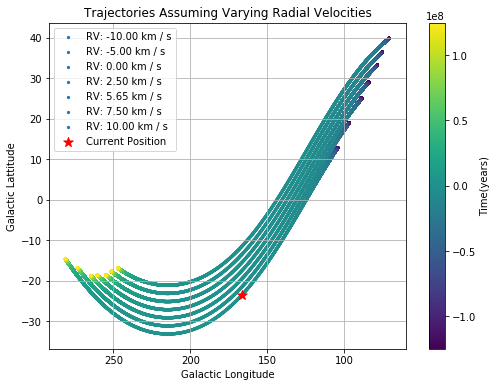

In [59]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

for i in rv_trials:
    pcm=ax.scatter(rv_trials[i]['spherical']['alpha'], rv_trials[i]['spherical']['delta']+i*2, s=5,
            label = 'RV: {:.2f}'.format(rv_trials[i]['rv']),c=tval[0])
ax.scatter(c.l, c.b,s=100,marker='*', color='red', label='Current Position')
#ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
#ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
ax.set_title('Trajectories Assuming Varying Radial Velocities')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Lattitude')
ax.legend()
ax.grid()
ax.invert_xaxis()
fig.colorbar(pcm, label='Time(years)')

In [60]:
from astropy.time import Time
def ngp_gc(epoch):
    """
    computes alpha and delta of north galactic pole and galactic center at epoch.
    """
    
    # quantities from Binney & Merrified 1998
    # alpha, delta
    ngp_j2000 = np.array([192.85948, 27.12825])
    gc_j2000 = np.array([266.405, -28.936])
    
    #julian centuries since the epoch
    

In [61]:
tt = Time('J2000.0', format='jyear_str')

In [62]:
tt

<Time object: scale='tt' format='jyear_str' value=J2000.000>

In [63]:
tt.mjd

51544.5

In [64]:
tt2 = Time('J2015.5', format='jyear_str')

In [65]:
tt2

<Time object: scale='tt' format='jyear_str' value=J2015.500>

In [66]:
tt2-tt

<TimeDelta object: scale='tt' format='jd' value=5661.375>

In [67]:
dt = tt2-tt

In [68]:
dt.tt

<TimeDelta object: scale='tt' format='jd' value=5661.375>

### experiment: What is angular separation after applying motion?

In [69]:
coords = cluster_known_members['alphaPer'].get_coords(recalc=True)

In [70]:
dt = 1e3*u.year
coords_future=coords.apply_space_motion(dt=dt)

In [71]:
seps = coords.separation(coords_future)

In [72]:
seps[:10].to_value(u.arcsecond)

array([32.24315606, 33.61880175, 33.04073547, 32.04862987, 34.38460656,
       32.39542206, 33.69546556, 34.27277427, 35.04637671, 33.02015481])

In [73]:
seps[:10].to_value(u.degree)

array([0.00895643, 0.00933856, 0.00917798, 0.0089024 , 0.00955128,
       0.00899873, 0.00935985, 0.00952022, 0.0097351 , 0.00917227])

In [74]:
#compare to 1000 years of cartesian
mu = np.sqrt(cluster_known_members['alphaPer'].objs.pmra**2 + cluster_known_members['alphaPer'].objs.pmdec**2) # should be mas/year

In [75]:
#divide by 1000 to convert to arcseconds per year then multiply by 10 years
mas_per_as = 1000
np.allclose(seps.to_value(u.arcsecond), mu*dt/mas_per_as)

True

Angular separation turns out to be same as euclidean motion applied for same number of years **only for small dt's**.

Perhaps the discrepancy is due to the calculation of RA and Dec way into the future. The next section shows that simple extrapolation works for small dt's but diverges for larger ones. 

**TO DO** Verify coord.separation(coord2) is the great circle distance

### experiment: Reproduce results of `apply_space_motion`

is it true that
\begin{align*}
\alpha_t &= \alpha_0 + \mu_\alpha * dt \\
\delta_t &= \delta_0 + \mu_\delta * dt
\end{align*}

where $\mu_\alpha = \mu_{\alpha*cos\delta}/cos\delta$

In [76]:
#refresh our coordinates
dt = 1e5*u.year
coords = cluster_known_members['alphaPer'].get_coords(recalc=True)
coords2 = coords.apply_space_motion(dt=dt)

In [77]:
mas_per_degree = 3.6e6

pm_ra = cluster_known_members['alphaPer'].objs.pmra/np.cos(np.radians(cluster_known_members['alphaPer'].objs.dec))
pm_dec = cluster_known_members['alphaPer'].objs.pmdec

alpha_t = cluster_known_members['alphaPer'].objs.ra + pm_ra*dt/mas_per_degree
delta_t = cluster_known_members['alphaPer'].objs.dec + pm_dec*dt/mas_per_degree

In [78]:
print(f'RA all close: {np.allclose(coords2.ra.to_value(u.degree), alpha_t)}')
print(f'Dec all close: {np.allclose(coords2.dec.to_value(u.degree), delta_t)}')

RA all close: False
Dec all close: False


Looks like the hand extrapolation holds for relatively small extrapolation periods. The ERFA warning is concerning.

Does the hand extrapolation hold for larger extrapolation periods? Let's compare what we get from `apply_space_motion` to our hand extrapolation for a range of extrapolation periods. We'll compute the root mean squared error between the two for both RA and Dec.

In [79]:
#function to compute root mean squared error btween output of apply_space_motion and hand extrapolation
def rmse_t(gstars, dt):
    
    mas_per_degree = 3.6e6
    
    coords = gstars.get_coords(recalc=True)
    coords2 = coords.apply_space_motion(dt=dt*u.year)
    
    pmra = gstars.objs.pmra/np.cos(np.radians(gstars.objs.dec))
    pmdec = gstars.objs.pmdec
    
    alpha_t = gstars.objs.ra  +  pmra*dt/mas_per_degree
    delta_t = gstars.objs.dec + pmdec*dt/mas_per_degree
    
    rmse_alpha = np.sqrt(((coords2.ra.to_value(u.degree) - alpha_t)**2).mean())
    rmse_delta = np.sqrt(((coords2.dec.to_value(u.degree) - delta_t)**2).mean())
    
    return (rmse_alpha, rmse_delta)
    
    

In [80]:
#range of extrapolation periods.  Apply_space_motion has an upperlimit, 1,000,000 years is below it.
dts=np.linspace(0,1e6,1001)

In [81]:
rmse = np.array([rmse_t(cluster_known_members['alphaPer'],dt) for dt in dts])

Text(0.5, 0.98, 'Apply_space_motion v. Hand Extrapolation')

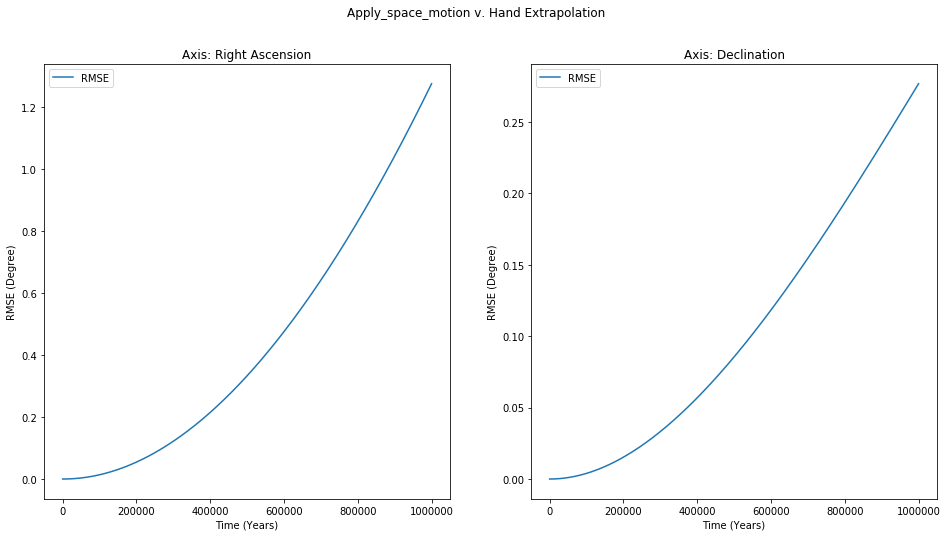

In [82]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)

for i,d in enumerate(['Right Ascension','Declination']):

    ax[i].plot(dts, rmse[:,i], label='RMSE')
    ax[i].set_title(f'Axis: {d}')
    ax[i].legend()
    ax[i].set_xlabel('Time (Years)')
    ax[i].set_ylabel('RMSE (Degree)')
    

fig.suptitle('Apply_space_motion v. Hand Extrapolation')

In [83]:
import pandas as pd
# first few rmse's
pd.DataFrame({'Years':dts[:11], 'RMSE_Alpha':rmse[:11,0]*mas_per_degree, 'RMSE_Delta': rmse[:11,1]*mas_per_degree})

,Years,RMSE_Alpha,RMSE_Delta
0,0.0,1.365897e-08,1.456741e-08
1,1000.0,4.987120e+00,1.474960e+00
2,2000.0,1.994690e+01,5.897909e+00
3,3000.0,4.487710e+01,1.326587e+01
4,4000.0,7.977545e+01,2.357585e+01
5,5000.0,1.246397e+02,3.682488e+01
6,6000.0,1.794676e+02,5.300999e+01
7,7000.0,2.442569e+02,7.212818e+01
8,8000.0,3.190054e+02,9.417648e+01
9,9000.0,4.037107e+02,1.191519e+02


### Experiment: What Radial Velocity does Astropy use by default?

Radial Velocity is necessary to convert from proper motion to space (Cartesian) velocity, or is it?

1. Get a set of coordinates **without** radial velocity
1. Confirm that astropy will produce cartesian velocity from these
1. Take resutling d_xyz and convert back to spherical velocity
1. examine the radial velocity produced

In [84]:
coords = cluster_known_members['alphaPer'].get_coords(recalc=True, default_rv=None)

In [85]:
coords[:5]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(53.99317995, 44.6362636 , 178.67261078),
     (53.39945019, 44.87074516, 177.29271356),
     (52.19095546, 45.45131878, 179.80757509),
     (52.35445158, 46.03389368, 183.80859721),
     (52.50721412, 45.93779473, 172.13395647)]
 (pm_ra_cosdec, pm_dec) in mas / yr
    [(20.84352531, -24.60017444), (21.50844164, -25.83816536),
     (21.8644442 , -24.77168341), (21.543012  , -23.72790187),
     (22.53087847, -25.97423157)]>

In [86]:
coords[:5].velocity.d_xyz.to(u.km/u.second)

<Quantity [[ -5.67507069,  -5.37759042,  -5.49944989,  -5.77430696,
             -5.31718511],
           [ 22.22126648,  23.0775644 ,  23.31325341,  23.24776604,
             23.27449726],
           [-14.82662359, -15.38992614, -14.81228043, -14.35329732,
            -14.7397361 ]] km / s>

In [87]:
conv = (1*u.pc/u.year).to(u.km/u.second)
conv

<Quantity 977792.22167313 km / s>

In [88]:
coords[:5].velocity

<CartesianDifferential (d_x, d_y, d_z) in mas pc / (rad yr)
    [(-1197.15347498, 4687.56564441, -3127.66922659),
     (-1134.40015245, 4868.20128539, -3246.49763253),
     (-1160.10634968, 4917.91977023, -3124.64354507),
     (-1218.08731881, 4904.10524094, -3027.8212744 ),
     (-1121.65768117, 4909.74417838, -3109.3403514 )]>

**To Do:** Figure out how astropy converts from mas pc /(rad yr) to km/s

In [89]:
eq_coords = cluster_known_members['alphaPer'].get_coords(recalc=True, default_rv=None)
xyz_act = eq_coords.cartesian.xyz.value
d_xyz_act = eq_coords.velocity.d_xyz.to_value(u.km/u.second)
pm_act = {'radial_velocity': eq_coords.radial_velocity,
          'pm_ra_cosdec': eq_coords.pm_ra_cosdec,
          'pm_dec':eq_coords.pm_dec}

pm_calc = dxyz_to_pm(xyz_act, d_xyz_act)

In [90]:
pm_calc['radial_velocity']

<Quantity [ 0.00000000e+00, -5.32907052e-15, -1.77635684e-15,
           -1.77635684e-15, -1.77635684e-15,  0.00000000e+00,
           -1.77635684e-15,  0.00000000e+00, -1.77635684e-15,
           -3.55271368e-15, -7.10542736e-15,  0.00000000e+00,
           -7.10542736e-15,  1.77635684e-15, -3.55271368e-15,
            0.00000000e+00,  1.77635684e-15,  1.77635684e-15,
            0.00000000e+00,  1.77635684e-15,  5.32907052e-15,
           -1.77635684e-15,  1.77635684e-15, -7.10542736e-15,
            1.77635684e-15,  0.00000000e+00, -5.32907052e-15,
           -1.77635684e-15,  1.77635684e-15,  1.77635684e-15,
            5.32907052e-15,  3.55271368e-15,  0.00000000e+00,
           -3.55271368e-15, -1.77635684e-15, -3.55271368e-15,
           -1.77635684e-15, -1.77635684e-15,  1.77635684e-15,
           -3.55271368e-15,  0.00000000e+00, -1.77635684e-15,
           -1.77635684e-15,  1.77635684e-15, -3.55271368e-15,
           -3.55271368e-15,  3.55271368e-15,  1.77635684e-15,
        

In [91]:
pm_calc['radial_velocity'].min(),pm_calc['radial_velocity'].max()

(<Quantity -1.0658141e-14 km / s>, <Quantity 1.0658141e-14 km / s>)

In [92]:
np.allclose(pm_calc['radial_velocity'], 0)

True

In [93]:
np.allclose(pm_calc['pm_ra_cosdec'], eq_coords.pm_ra_cosdec), np.allclose(pm_calc['pm_dec'], eq_coords.pm_dec)

(True, True)

Taking the cartesian velocity from coordinates without radail velocity, and converting them back to spherical, produces a radial velocity that is very close to zero but not exactly so. The same transformation recovers the `pm_ra_cosdec` and `pm_dec` values.

Let's make a set of coordinates where we stuff in the value of 0.0 km/s for radial velocity as if that was the value actually observed.  Compare the space velocity from these coordinates to those from the coordinates for which we supplied no radial velocity values (eq_coords from above)

In [94]:
from astropy.coordinates import SkyCoord
objs = cluster_known_members['alphaPer'].objs
#create coordinates with 0 km/s for all observations
coords3 = SkyCoord(ra=np.array(objs.ra)*u.degree, dec = np.array(objs.dec)*u.degree, distance = np.array(objs.r_est)*u.pc,
                   pm_ra_cosdec = np.array(objs.pmra)*u.mas/u.year, pm_dec = np.array(objs.pmdec)*u.mas/u.year,
                   radial_velocity = 0.0*u.km/u.second)


In [95]:
coords3[:5]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(53.99317995, 44.6362636 , 178.67261078),
     (53.39945019, 44.87074516, 177.29271356),
     (52.19095546, 45.45131878, 179.80757509),
     (52.35445158, 46.03389368, 183.80859721),
     (52.50721412, 45.93779473, 172.13395647)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(20.84352531, -24.60017444, 0.), (21.50844164, -25.83816536, 0.),
     (21.8644442 , -24.77168341, 0.), (21.543012  , -23.72790187, 0.),
     (22.53087847, -25.97423157, 0.)]>

In [96]:
coords3[:5].velocity.d_xyz.value

array([[ -5.67507069,  -5.37759042,  -5.49944989,  -5.77430696,
         -5.31718511],
       [ 22.22126648,  23.0775644 ,  23.31325341,  23.24776604,
         23.27449726],
       [-14.82662359, -15.38992614, -14.81228043, -14.35329732,
        -14.7397361 ]])

In [97]:
d_xyz_act[:,:5]

array([[ -5.67507069,  -5.37759042,  -5.49944989,  -5.77430696,
         -5.31718511],
       [ 22.22126648,  23.0775644 ,  23.31325341,  23.24776604,
         23.27449726],
       [-14.82662359, -15.38992614, -14.81228043, -14.35329732,
        -14.7397361 ]])

In [98]:
np.allclose(coords3.velocity.d_xyz.value, d_xyz_act)

True

The cells above show that when no radial velocity is supplied to the coordinate definition, astropy uses a default $rv=0.0 \frac{km}{s}$ when it converts to cartesian velocity.

### How to get from `mas pc / (rad yr)` to `km/s`?

In [99]:
#conversions
km_per_pc = (1*u.pc).to_value(u.km)
seconds_per_year = (1*u.year).to_value(u.second)
mas_per_degree = (1*u.degree).to_value(u.mas)
radian_per_mas = (1*u.mas).to_value(u.radian)

In [100]:
km_per_pc, seconds_per_year, mas_per_degree, radian_per_mas

(30856775814671.914, 31557600.0, 3599999.9999999995, 4.84813681109536e-09)

In [101]:
coords[:5].velocity.d_xyz*km_per_pc*radian_per_mas/(seconds_per_year)

<Quantity [[ -5.67507069,  -5.37759042,  -5.49944989,  -5.77430696,
             -5.31718511],
           [ 22.22126648,  23.0775644 ,  23.31325341,  23.24776604,
             23.27449726],
           [-14.82662359, -15.38992614, -14.81228043, -14.35329732,
            -14.7397361 ]] mas pc / (rad yr)>

In [102]:
coords[:5].velocity.d_xyz.to(u.km/u.second)

<Quantity [[ -5.67507069,  -5.37759042,  -5.49944989,  -5.77430696,
             -5.31718511],
           [ 22.22126648,  23.0775644 ,  23.31325341,  23.24776604,
             23.27449726],
           [-14.82662359, -15.38992614, -14.81228043, -14.35329732,
            -14.7397361 ]] km / s>

In [103]:
np.allclose(coords.velocity.d_xyz.to(u.km/u.second).value, (coords.velocity.d_xyz*km_per_pc*radian_per_mas/(seconds_per_year)).value )

True

To get from `

In [104]:
# Z the coordinate system
Z = np.array([[1,0,0],[0,1,0],[0,0,1]])
Z

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [105]:
a = np.array([1,2,3]).reshape(3,1)

In [106]:
Z.dot(a)

array([[1],
       [2],
       [3]])

In [107]:
Z.T.dot(a)

array([[1],
       [2],
       [3]])

In [109]:
b=np.array([10,20,30]).reshape(3,1)

In [112]:
def get_triads(objs):
    cos_alpha = np.cos(np.radians(objs.ra));  sin_alpha = np.sin(np.radians(objs.ra))
    cos_delta = np.cos(np.radians(objs.dec)); sin_delta = np.sin(np.radians(objs.dec))
    
    n = len(cos_alpha)
    
    #form the p, q, r triads: each 3 x n
    p = np.array([-1.0*sin_alpha, cos_alpha, np.zeros(n)]).reshape(3,n)
    q = np.array([-1.0*sin_delta*cos_alpha, -1.0*sin_delta*sin_alpha, cos_delta]).reshape(3,n)
    r = np.array([cos_delta*cos_alpha, cos_delta*sin_alpha, sin_delta]).reshape(3,n)
    
    return {'p':p, 'q':q, 'r':r}
    

In [2]:
import numpy as np

In [3]:
xx = np.array([True, False, True, False])
yy = np.array([True, True, False, True])

In [4]:
xx & yy

array([ True, False, False, False])

In [5]:
xx | yy

array([ True,  True,  True,  True])

In [6]:
True | False

True

In [7]:
xx and yy

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()